## Dataset:
### The data has 40K+ reviews in Arabic for sentiment analysis each labelled with a rating and its associated company name


### imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import random
import helpers
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import arabic_reshaper
from nltk.corpus import stopwords
from imageio import imread
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session

In [2]:
#The following are options that will apear on the Word-Cloud plot later on.
mpl.style.use('ggplot')
infosize = 12
limit = 10000
title = 'Most frequent words'
chartinfo = 'Author: Ali Al-Julaih'
footer = 'The {} most frequent words, excluding stopwords.\n{}'.format(limit, chartinfo)
font = r'C:/Users/aliha/NotoNaskhArabic-Regular.ttf'#font needed to display arabic text
fontcolor='#000000'
bgcolor = '#000000'

In [3]:
#loading English and German stop-words then combining the two sets in one

import nltk

nltk.download('wordnet')#you may turn this one off if you've already downloaded the wordnet   
nltk.download('stopwords')#download the stopword lists from NLTK. Can be turned off if already downloaded
en_stop = set(nltk.corpus.stopwords.words('english'))
ar_stop = set(nltk.corpus.stopwords.words('arabic'))

both_stop_words = en_stop.union(ar_stop)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aliha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aliha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
pd.set_option('display.max_colwidth', -1)

In [5]:
seed = 42

## Preprocessing

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Reading a the 2019 CCC talks, which is stored as a CSV file
data = pd.read_csv("CompanyReviews.csv", delimiter=',', header=0, encoding='utf8')#notice the delimiter is not a comma, check your files first.
print('Number of titles: {:,}\n'.format(data.shape[0]))
data.sample(5)

Number of titles: 40,046



,Unnamed: 0,review_description,rating,company
27780,27780,مره روعه يجنن,1,talbat
33998,33998,هو معقول تلغو الرحلة وانا حاجز ودافع .. ايه المستوى ده .. الساعة تسعة بالليل في القاهرة وانا سبت عربيتي وركبت معاكم ذهابا وسبتوني ايابا ..,-1,swvl
12286,12286,تطبيق ممتاز.. ومنقذ بنفس الوقت..,1,talbat
10116,10116,احقر تطبيق,-1,talbat
3398,3398,عند الطلب ويسحب الفلوس من البطاقه.. يطلعلك في الطلب خطأ فل موقع . ولاكن الطلب ساري اجرأته يرجي تعديل وتحديث في الموقع وتحديثه بشكل افظل وشكران,-1,talbat


In [7]:
tweets_dict = {}

# classify that the article has recommends
for i in range(len(data)):
    if data["review_description"][i] in tweets_dict.keys():
        tweets_dict[data["review_description"][i]] += 1
    else:
        tweets_dict.setdefault(data["review_description"][i], 1)

tweets_dict = [x for x in tweets_dict if str(x) != 'nan']#some talks have no abstracts
#print(tweets_dict)

In [8]:
data.rename(columns={"Unnamed: 0": "NO_of_reviews"}, inplace=True)

In [9]:
data.info() #it helps in getting a quick overview of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40046 entries, 0 to 40045
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   NO_of_reviews       40046 non-null  int64 
 1   review_description  40045 non-null  object
 2   rating              40046 non-null  int64 
 3   company             40046 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.2+ MB


In [10]:
data.shape   #it shows the number of dimensions as well as the size in each dimension.

(40046, 4)

In [11]:
data.describe()   #Return a statistical summary for numerical columns present in the datset

,NO_of_reviews,rating
count,40046.000000,40046.000000
mean,19521.781876,0.242746
std,11553.156518,0.945001
min,0.000000,-1.000000
25%,9506.250000,-1.000000
50%,19517.500000,1.000000
75%,29528.750000,1.000000
max,39540.000000,1.000000


In [12]:
data.isnull().sum()  #Return the number of missing values in aech column

NO_of_reviews         0
review_description    1
rating                0
company               0
dtype: int64

In [13]:
data.nunique()    #Return number of unique elements in the object

NO_of_reviews         39541
review_description    39003
rating                3    
company               12   
dtype: int64

In [14]:
data['rating'].value_counts()    #This function is used to get a series containing counts of unique values

 1    23921
-1    14200
 0    1925 
Name: rating, dtype: int64

### include all reviews

In [15]:
data = data[data.rating.isin([-1, 0, 1])]

### Apply text preprocessing/cleaning

### Remove empty string reviews

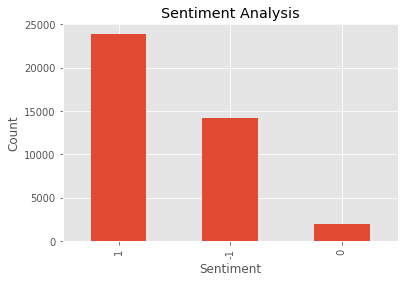

In [16]:
import matplotlib.pyplot as plt

data['rating'].value_counts()

plt.title("Sentiment Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Count")
data['rating'].value_counts().plot(kind='bar')
plt.show()

In [17]:
pol = data['rating']
m = pd.Series(pol)

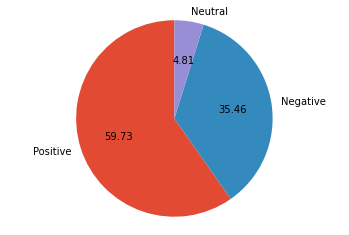

In [18]:
# classifying polarity into categories 'pos' (positive), 'neg' (negative), and 'neu' (neutral)
pos=0
neg=0
neu=0

for items in m:
    if items>0:
        pos=pos+1
    elif items<0:
        neg=neg+1
    else:
        neu=neu+1
        
# creating a pie chart showing the polarity distribution among Netflix related tweets
pieLabels=["Positive","Negative","Neutral"]

populationShare=[pos,neg,neu]

figureObject, axesObject = plt.subplots()

axesObject.pie(populationShare,labels=pieLabels,autopct='%1.2f',startangle=90)

axesObject.axis('equal')

plt.show()

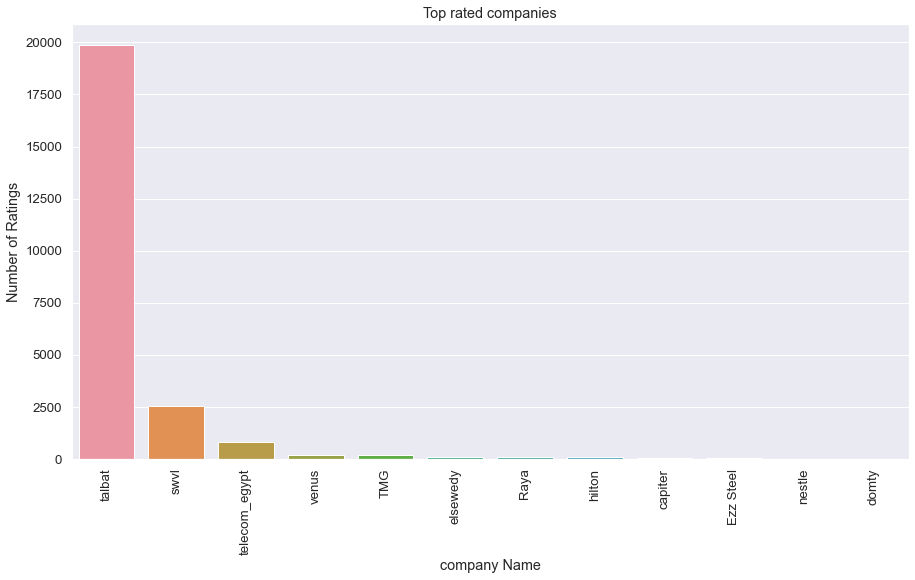

In [19]:
import seaborn as sns

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]


rating = dict(data.loc[data.rating == 1, "company"].value_counts())
company = list(rating.keys())
company_rating = list(rating.values())
sns_rating = sns.barplot(x = company[0:20], y = company_rating[0:20])
sns_rating.set_title('Top rated companies')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("company Name")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

Text(0.5, 0, 'Rating')

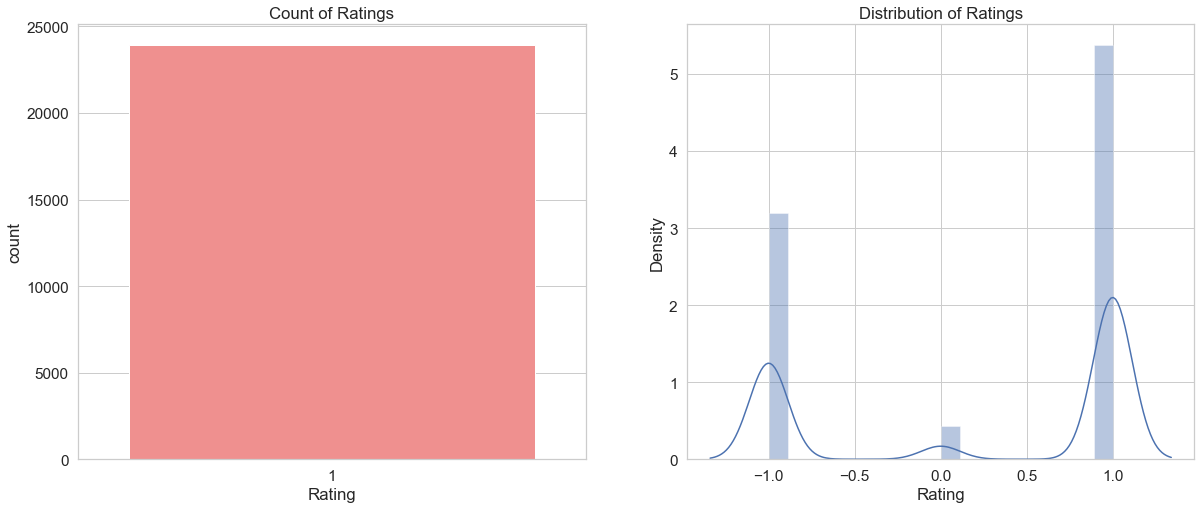

In [20]:
plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'whitegrid')
fig, ax = plt.subplots(1, 2)


sns_1 = sns.countplot(data['rating'], palette = 'spring', order = list(range(1, 0, -1)), ax = ax[0])
sns_2 = sns.distplot(data['rating'], ax = ax[1])
sns_1.set_title('Count of Ratings')
sns_1.set_xlabel("Rating")

sns_2.set_title('Distribution of Ratings')
sns_2.set_xlabel("Rating")

In [21]:
#a method for a grey colour wordcloud
def grenshades_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(100,100%%, %d%%)' % random.randint(0, 300)

source: https://github.com/yassineMrabet/Word_Cloud_Arabic


(-0.5, 1199.5, 1451.5, -0.5)

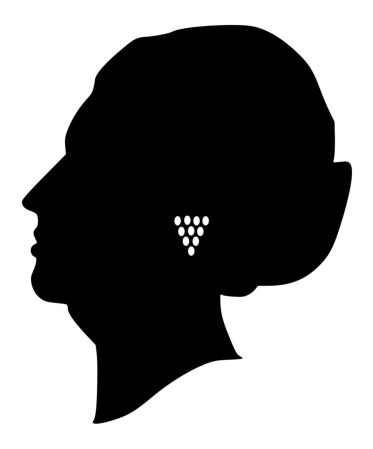

In [22]:
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
from bidi.algorithm import get_display

mask = np.arrayim = (Image.open(r"C:\Users\aliha\Oum_Kalthoum.png")) # source: https://github.com/yassineMrabet/Word_Cloud_Arabic 
plt.imshow(mask)
print("source: https://github.com/yassineMrabet/Word_Cloud_Arabic")
plt.axis("off")

In [23]:
import re
review_description = " ".join(x for x in tweets_dict)

review_description = re.sub('[^ا-ي -\']+', '', review_description)
review_description = review_description.replace('>', ' ').replace('<', ' ')
review_description = re.sub(' +', ' ', review_description)

review_description = arabic_reshaper.reshape(review_description)
review_description = get_display(review_description) # add this line

In [24]:
wordcloud = WordCloud(
    max_words=limit,
    stopwords=both_stop_words,
    mask=imread(r"C:\Users\aliha\Oum_Kalthoum.png"),
    background_color=bgcolor,
    font_path=font
).generate(review_description)

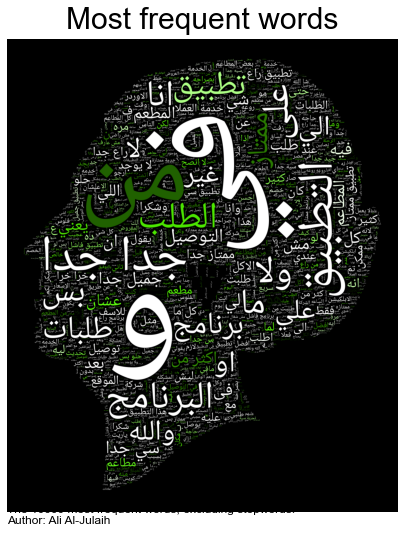

In [25]:

#set width and height
fig = plt.figure()
fig.set_figwidth(7)
fig.set_figheight(10)

#plot!
plt.imshow(wordcloud.recolor(color_func=grenshades_color, random_state=10))
plt.title(title, color=fontcolor, size=30, y=1.01)
plt.annotate(footer, xy=(0, -.025), xycoords='axes fraction', fontsize=infosize, color=fontcolor)
plt.axis('off')
plt.show()

In [26]:
%%capture
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
import nltk
import re
import math
#nltk.download('stopwords') #uncomment if not downloaded
ar_stop = set(nltk.corpus.stopwords.words('arabic'))

def clean_sentence(text):
    text = ''.join([i for i in text if not i.isdigit()])
    text = text.replace('>', ' ').replace('<', ' ')
    text = re.sub(' +', ' ', text)
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', text).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in ar_stop or len(word) < 3:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

In [28]:
import arabic_reshaper # this was missing in your code
from bidi.algorithm import get_display

def build_corpus(columnData):
    corpus = []
    for i in range(len(data)):
        if str(columnData[i]) != 'nan':
            sentence = clean_sentence(columnData[i])
            sentence = arabic_reshaper.reshape(sentence)
            sentence = get_display(sentence) # add this line
            word_list = sentence.split(" ")
            corpus.append(word_list)
    return corpus

corpus = build_corpus(data["review_description"])

In [29]:
print("[",data["review_description"][0],"],[",data["review_description"][1],"]")#original first two sentences as in the CSV file
print(corpus[0:2])#first two sentences after cleaning and removing stop words

[ رائع ],[ برنامج رائع جدا يساعد على تلبيه الاحتياجات بشكل اسرع ]
[['ﻊﺋﺍﺭ'], ['ﻉﺮﺳﺍ', 'ﻞﻜﺸﺑ', 'ﺕﺎﺟﺎﻴﺘﺣﻻﺍ', 'ﻪﻴﺒﻠﺗ', 'ﺪﻋﺎﺴﻳ', 'ﺍﺪﺟ', 'ﻊﺋﺍﺭ', 'ﺞﻣﺎﻧﺮﺑ']]


In [30]:
#Word2Vec model
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
#The Word to Vec model produces a vocabulary, with each word being represented by an n-dimensional numpy array (100 values in this example)
model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4,sg=0)#sg refers to skip-gram and here it's off and by default we are using a CBOW. #CBOW tries to predict a word on the basis of its neighbors, while Skip Gram tries to predict the neighbors of a word. In simpler words, CBOW tends to find the probability of a word occurring in a context. So, it generalizes over all the different contexts in which a word can be used.
model.save("word2vec.model")

In [31]:
%%capture
#Plotting similarities of a word embedding model using a scatter plot from t-SNE
#(t-SNE) t-Distributed Stochastic Neighbor Embedding is a non-linear dimensionality reduction algorithm used for exploring high-dimensional data. It maps multi-dimensional data to two or more dimensions suitable for human observation. With help of the t-SNE algorithms, you may have to plot fewer exploratory data analysis plots next time you work with high dimensional data.
def tsne_plot(model,modelName):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    pltFileName = 'plots'+'/'+'word_embeddings'+'_'+modelName+'.pdf';
    plt.savefig(pltFileName)
    plt.show()

In [32]:
model10 = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=40, workers=4,sg=0)#sg refers to skip-gram and here it's off and by default we are using a CBOW. #CBOW tries to predict a word on the basis of its neighbors, while Skip Gram tries to predict the neighbors of a word. In simpler words, CBOW tends to find the probability of a word occurring in a context. So, it generalizes over all the different contexts in which a word can be used.
model.save("word2vec.model")

### Balance input data 

In [33]:
min_sample = data.groupby(['rating']).count().review_description.min()
input_data = pd.concat([data[data.rating == 1].head(min_sample), 
                        data[data.rating == -1].head(min_sample),
                        data[data.rating == 0].head(min_sample)])
input_data.groupby(['rating']).count()

,NO_of_reviews,review_description,company
rating,,,
-1,1925,1925,1925
0,1925,1925,1925
1,1925,1925,1925


### Create Numpy Arrays

In [34]:
X = input_data.review_description.values

In [35]:
Y = np.asarray(input_data.rating.values).astype('float32')
Y = Y.clip(0, 1)

### Create Sequences

In [36]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

vocab_size = len(tokenizer.word_index) + 1
print("vocab size:", vocab_size)

vocab size: 15345


In [37]:
maxlen = 300
X = pad_sequences(X, padding='post', maxlen=maxlen)

### Store tokenizer

In [38]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

### Split Data

In [39]:
X_train, X_test, label_train, label_test = train_test_split(X, Y, test_size=0.33,
                                                            random_state=seed)

In [40]:
print("Training:", len(X_train), len(label_train))
print("Testing: ", len(X_test), len(label_test))

Training: 3869 3869
Testing:  1906 1906


## Create Model
#### Bidirectional LSTM model:

In [41]:
embedding_dim = 100
dropout = 0.5
opt = 'adam'
clear_session()

model = Sequential()
model.add(layers.Embedding(input_dim=num_words, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Bidirectional(layers.LSTM(100, dropout=dropout, 
                                           recurrent_dropout=dropout, 
                                           return_sequences=True)))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 300, 200)         160800    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8

### Training

In [42]:
history = model.fit(X_train, label_train,
                    epochs=4,
                    verbose=True,
                    validation_data=(X_test, label_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, label_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss_val, accuracy_val = model.evaluate(X_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))

Epoch 1/4
61/61 [==============================] - 272s 4s/step - loss: 0.6425 - accuracy: 0.6681 - val_loss: 0.6090 - val_accuracy: 0.6422
Epoch 2/4
61/61 [==============================] - 253s 4s/step - loss: 0.5743 - accuracy: 0.6774 - val_loss: 0.5299 - val_accuracy: 0.6422
Epoch 3/4
61/61 [==============================] - 237s 4s/step - loss: 0.4461 - accuracy: 0.7550 - val_loss: 0.4921 - val_accuracy: 0.7838
Epoch 4/4
121/121 [==============================] - 27s 226ms/step - loss: 0.2634 - accuracy: 0.9062
Training Accuracy: 0.9062
60/60 [==============================] - 15s 245ms/step - loss: 0.5695 - accuracy: 0.7907
Testing Accuracy:  0.7907


In [43]:
def plot_history(history, param):
    """
    Shows how the model performs (in terms of accuracy and loss) over several epochs.
    """
    
    if param == 'acc':
        ax = plt.subplot()
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        ax = plt.subplots()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

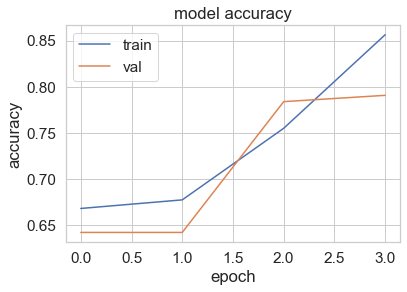

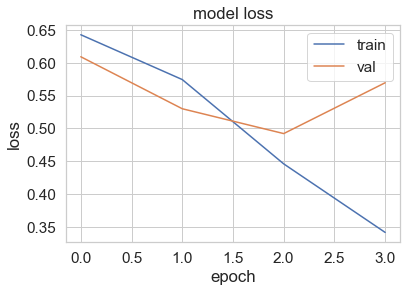

In [44]:
plot_history(history, 'acc')
plot_history(history, 'loss')

### Evaluation

In [45]:
blind_sample = 400
blind_test = pd.concat([data[data.rating == 1].head(blind_sample), 
                        data[data.rating == -1].head(blind_sample),
                        data[data.rating == 0].head(blind_sample)])

### Create Numpy arrays

In [46]:
X_blind = blind_test.review_description.values
Y_blind = np.asarray(blind_test.rating.values).astype('float32')
Y_blind = Y_blind.clip(0, 1)

### Create sequences

In [47]:
X_blind = tokenizer.texts_to_sequences(X_blind)
X_blind = pad_sequences(X_blind, padding='post', maxlen=maxlen)

### Predict

In [48]:
pred_blind = model.predict(X_blind, verbose=True)

38/38 [==============================] - 9s 224ms/step


### Compre results

In [49]:
df_blind = pd.DataFrame({'REAL': Y_blind, 
                         'PRED': pred_blind.reshape(pred_blind.shape[0],), 
                         'TEXT': blind_test.review_description})
df_blind = df_blind.reset_index()[['REAL', 'PRED', 'TEXT']]
df_blind.PRED = df_blind.PRED.round()
error_records = df_blind[df_blind.REAL != df_blind.PRED]

In [50]:
print("Number of misclassified reviews: {} out of {}".format(error_records.shape[0], df_blind.shape[0]))
print("Blind Test Accuracy:  {:.4f}".format(accuracy_score(df_blind.REAL, df_blind.PRED)))

Number of misclassified reviews: 173 out of 1200
Blind Test Accuracy:  0.8558


In [51]:
df_blind.sample(n=10)

,REAL,PRED,TEXT
741,0.0,1.0,انا حر
410,0.0,0.0,الضريبه عالية جداً
1102,0.0,1.0,حلو ومش حلو
335,1.0,0.0,لا والله رنبتغاتنقخفعحغهعغمغنتت
68,1.0,1.0,فخميين
491,0.0,0.0,سي جدا تم دن افضل
212,1.0,1.0,ممتاز وسريع
927,0.0,0.0,قيمته ٣ نجوم لانه منيح بس اولا مافي رقم للاستفسار وثانيا قسيمه طلبات مارت من وين اجيب رمزها بتمنى الاقي يساعدني
1177,0.0,0.0,فيه موصلين طعام أولاد حرام وأيضاً يوجد مشكلة تحويل التطبيق للغة بشكل تلقائي دائمآ أواجه هذه المشكلة أتمنى حلها في أسرع وقت.
1046,0.0,1.0,0pp


### Store Model and Weights